## Import

In [43]:
import os
import numpy as np
from scipy.stats import mode
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from braindecode import EEGClassifier
from torch.nn import CrossEntropyLoss
from skorch.dataset import ValidSplit
import pandas as pd
from braindecode.models import EEGNetv4

In [44]:
def plot_confusion_matrices(cm, label_mapping, experiment_name):
    """Plotta le confusion matrix"""
    labels = [k for k, v in sorted(label_mapping.items(), key=lambda x: x[1])]
    
    # Normalizza la confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Confusion matrix non normalizzata
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=labels, yticklabels=labels, ax=ax1)
    ax1.set_title(f"Confusion Matrix - {experiment_name}")
    ax1.set_xlabel("Predicted Label")
    ax1.set_ylabel("True Label")
    
    # Confusion matrix normalizzata
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=labels, yticklabels=labels, ax=ax2)
    ax2.set_title(f"Normalized Confusion Matrix - {experiment_name}")
    ax2.set_xlabel("Predicted Label")
    ax2.set_ylabel("True Label")
    
    plt.tight_layout()
    plt.show()

## Funzioni

In [45]:
def calculate_final_metrics(all_segment_true, all_segment_pred, all_subject_true, all_subject_pred, 
                          subject_results, segment_accuracies, label_mapping, experiment_name):
    """Calcola e stampa tutte le metriche finali"""
    
    print(f"\n" + "="*50)
    print(f"📈 RISULTATI FINALI - {experiment_name}")
    print("="*50)
    
    # Metriche sui segmenti
    seg_acc = accuracy_score(all_segment_true, all_segment_pred)
    seg_prec = precision_score(all_segment_true, all_segment_pred, average='weighted', zero_division=0)
    seg_rec = recall_score(all_segment_true, all_segment_pred, average='weighted', zero_division=0)
    seg_f1 = f1_score(all_segment_true, all_segment_pred, average='weighted', zero_division=0)
    
    print("\nMETRICHE SUI SEGMENTI:")
    print(f"Accuracy: {seg_acc:.3f} ± {np.std(segment_accuracies):.3f}")
    print(f"Precision: {seg_prec:.3f}")
    print(f"Recall: {seg_rec:.3f}")
    print(f"F1-Score: {seg_f1:.3f}")
    
    # Metriche sui soggetti (moda)
    subj_acc = accuracy_score(all_subject_true, all_subject_pred)
    subj_prec = precision_score(all_subject_true, all_subject_pred, average='weighted', zero_division=0)
    subj_rec = recall_score(all_subject_true, all_subject_pred, average='weighted', zero_division=0)
    subj_f1 = f1_score(all_subject_true, all_subject_pred, average='weighted', zero_division=0)
    
    subject_acc_values = [r['correct'] for r in subject_results]
    
    print("\nMETRICHE SUI SOGGETTI (Moda):")
    print(f"Accuracy: {subj_acc:.3f} ± {np.std(subject_acc_values):.3f}")
    print(f"Precision: {subj_prec:.3f}")
    print(f"Recall: {subj_rec:.3f}")
    print(f"F1-Score: {subj_f1:.3f}")
    
    # Stampa risultati per soggetto
    print("\nRISULTATI PER SOGGETTO:")
    for result in subject_results:
        status = "Y" if result['correct'] else "N"
        print(f"{status} {result['subject']}: {result['true_label']} → {result['pred_label']} "
              f"(seg_acc: {result['segment_accuracy']:.3f}, n_seg: {result['n_segments']})")
    
    # Classification report
    print("\n🔸 CLASSIFICATION REPORT (Soggetti):")
    
    # Ottieni le classi uniche effettivamente presenti nei dati
    unique_classes = sorted(set(all_subject_true + all_subject_pred))
    
    # Crea target_names basati sulle classi uniche
    if len(unique_classes) == len(set(label_mapping.values())):
        # Caso normale: ogni valore numerico corrisponde a una sola etichetta
        inverse_mapping = {v: k for k, v in label_mapping.items()}
        target_names = [inverse_mapping[cls] for cls in unique_classes]
    else:
        # Caso speciale: alcune classi sono mappate allo stesso valore (es. A e F -> 1)
        # Trova tutte le etichette che mappano a ciascuna classe numerica
        class_to_labels = {}
        for label, numeric in label_mapping.items():
            if numeric not in class_to_labels:
                class_to_labels[numeric] = []
            class_to_labels[numeric].append(label)
        
        target_names = []
        for cls in unique_classes:
            if len(class_to_labels[cls]) == 1:
                target_names.append(class_to_labels[cls][0])
            else:
                # Se più etichette mappano alla stessa classe, uniscile
                target_names.append('+'.join(sorted(class_to_labels[cls])))
    
    print(classification_report(all_subject_true, all_subject_pred, target_names=target_names))
    
    # Confusion Matrix
    cm_subjects = confusion_matrix(all_subject_true, all_subject_pred)
    plot_confusion_matrices(cm_subjects, label_mapping, experiment_name)
    
    # Prepara risultati per return
    results = {
        'experiment_name': experiment_name,
        'n_subjects': len(subject_results),
        'n_segments_total': len(all_segment_true),
        
        # Metriche segmenti
        'segments': {
            'accuracy': seg_acc,
            'accuracy_std': np.std(segment_accuracies),
            'precision': seg_prec,
            'recall': seg_rec,
            'f1_score': seg_f1
        },
        
        # Metriche soggetti
        'subjects': {
            'accuracy': subj_acc,
            'accuracy_std': np.std(subject_acc_values),
            'precision': subj_prec,
            'recall': subj_rec,
            'f1_score': subj_f1
        },
        
        'subject_results': subject_results,
        'confusion_matrix': cm_subjects.tolist()
    }
    
    return results


In [46]:
def evaluate_loso_models(experiment_name, memmap_dir, all_subjects, true_labels, subject_to_recordings, label_mapping, net):
    """
    Carica i modelli LOSO salvati e calcola le metriche di valutazione complete.
    
    Args:
        experiment_name (str): Nome dell'esperimento
        memmap_dir (str): Directory dove sono salvati i modelli
        all_subjects (list): Lista di tutti i soggetti
        true_labels (dict): Etichette vere per ogni soggetto
        subject_to_recordings (dict): Registrazioni per ogni soggetto
        label_mapping (dict): Mappatura etichette stringa -> intero
    
    Returns:
        dict: Risultati completi dell'esperimento LOSO
    """
    
    save_dir = os.path.join(memmap_dir, experiment_name)
    inverse_mapping = {v: k for k, v in label_mapping.items()}
    
    # Liste per raccogliere tutte le predizioni
    all_segment_true = []
    all_segment_pred = []
    all_subject_true = []
    all_subject_pred = []
    
    # Liste per accuracies individuali
    segment_accuracies = []
    subject_results = []
    
    print(f"\nEvaluating LOSO experiment: {experiment_name}")
    print(f"Found models directory: {save_dir}")
    
    for left_out_subject in all_subjects:
        model_path = os.path.join(save_dir, f"model_test_LOSO_noSubject_{left_out_subject}.pt")
        
        if not os.path.exists(model_path):
            print(f"⚠️  Modello non trovato per {left_out_subject}: {model_path}")
            continue
            
        print(f"\nEvaluating subject: {left_out_subject}")
        
    
        
        # Carica i parametri del modello salvato
        net.load_params(model_path)
        
        # Prepara i dati di test per il soggetto lasciato fuori
        X_test = np.stack(subject_to_recordings[left_out_subject])
        true_label_subject = true_labels[left_out_subject]
        true_label_numeric = label_mapping[true_label_subject]
        
        # Crea le etichette per tutti i segmenti del soggetto
        y_test_segments = [true_label_numeric] * len(subject_to_recordings[left_out_subject])
        
        # Predici sui segmenti
        y_pred_segments = net.predict(X_test)
        
        # Calcola accuracy sui segmenti
        segment_acc = accuracy_score(y_test_segments, y_pred_segments)
        segment_accuracies.append(segment_acc)
        
        # Aggiungi alle liste globali per metriche complessive sui segmenti
        all_segment_true.extend(y_test_segments)
        all_segment_pred.extend(y_pred_segments)
        
        # Calcola predizione del soggetto tramite moda
        subject_pred_numeric = mode(y_pred_segments, keepdims=True).mode[0]
        subject_pred_label = inverse_mapping[subject_pred_numeric]
        
        # Risultato per questo soggetto
        subject_correct = (subject_pred_numeric == true_label_numeric)
        subject_results.append({
            'subject': left_out_subject,
            'true_label': true_label_subject,
            'pred_label': subject_pred_label,
            'correct': subject_correct,
            'segment_accuracy': segment_acc,
            'n_segments': len(y_pred_segments)
        })
        
        # Aggiungi alle liste globali per metriche sui soggetti
        all_subject_true.append(true_label_numeric)
        all_subject_pred.append(subject_pred_numeric)
        
        print(f"   True: {true_label_subject}, Pred: {subject_pred_label}, "
              f"Correct: {subject_correct}, Seg_Acc: {segment_acc:.3f}")
    
    # Calcola metriche finali
    results = calculate_final_metrics(
        all_segment_true, all_segment_pred,
        all_subject_true, all_subject_pred,
        subject_results, segment_accuracies,
        label_mapping, experiment_name
    )
    
    return results

## Subject_to_Recording and DataFrame

In [47]:
df = pd.read_csv("Data/participants.tsv", sep="\t")

In [48]:
import mne
import os
import numpy as np
import re
import pandas as pd

#TODO: Warning: NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


base_path = "Data"
desired_channels = ['C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8',
                    'Fp1', 'Fp2', 'Fz', 'O1', 'O2', 'P3', 'P4',
                    'Pz', 'T3', 'T4', 'T5', 'T6']
desired_n_times = 1000  # Numero di campioni per segmento
desired_sfreq = 500     # Frequenza di campionamento desiderata (Hz)

patient_epochs = []
patient_labels = []  # Lista per salvare le label per ogni segmento (epoch)

def extract_subject_number(subdir_name):
    match = re.search(r'\d+', subdir_name)
    return int(match.group()) if match else float('inf')

# Ottieni e ordina le sottodirectory dei soggetti
subdirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
subdirs_sorted = sorted(subdirs, key=extract_subject_number)


subject_to_recordings = {} # per salvare le registrazioni per ogni soggetto

for subdir in subdirs_sorted:
    subdir_path = os.path.join(base_path, subdir)
    eeg_path = os.path.join(subdir_path, 'eeg')
    if os.path.isdir(eeg_path):
        # Trova il file .set (EEGLAB)
        set_file = next((f for f in os.listdir(eeg_path) if f.endswith('.set')), None)
        if set_file:
            set_path = os.path.join(eeg_path, set_file)
            raw = mne.io.read_raw_eeglab(set_path, preload=True)
            
            # Seleziona solo i canali desiderati
            raw.pick_channels(desired_channels)
            
            # Risample se necessario
            if raw.info['sfreq'] != desired_sfreq:
                raw.resample(desired_sfreq)
            
            # Ottieni il numero di campioni della registrazione (puoi anche usare il JSON, se presente)
            n_samples = raw.n_times  
              
            
          
            # Suddividi l'intera registrazione in segmenti di 'desired_n_times' campioni
            segments = []
            for start in range(0, n_samples, desired_n_times):
                end = start + desired_n_times
                if end <= n_samples:
                    seg_data = raw[:, start:end][0]
                else:
                    # Se l'ultimo segmento è più corto, aggiungi padding con zeri
                    seg_data = raw[:, start:n_samples][0]
                    padding = np.zeros((len(desired_channels), desired_n_times - seg_data.shape[1]))
                    seg_data = np.hstack((seg_data, padding))
                segments.append(seg_data)
                 
            
            # Crea un array 3D: (numero_di_segmenti, numero_di_canali, desired_n_times)
            epochs_data = np.array(segments)
            n_epochs = epochs_data.shape[0]
            
            # Crea l'oggetto info e l'array degli eventi con tempi univoci
            info = mne.create_info(ch_names=desired_channels, sfreq=desired_sfreq, ch_types='eeg')
            events = np.array([[i * desired_n_times, 0, 1] for i in range(n_epochs)])
            
            epochs = mne.EpochsArray(epochs_data, info=info, events=events)
            patient_epochs.append(epochs)
            
            # Associa la label del soggetto: cerca in df la riga in cui la colonna 'Subject' corrisponde a subdir
            subj_label = df.loc[df['participant_id'] == subdir, 'Group'].values[0]
            # Ripeti la label per ogni segmento estratto per questo soggetto
            patient_labels.extend([subj_label] * n_epochs)

            if subdir not in subject_to_recordings:
                subject_to_recordings[subdir] = []
            subject_to_recordings[subdir].extend(segments)
        else:
            print(f"Nessun file .set trovato in {eeg_path}")
    else:
        print(f"La directory {eeg_path} non esiste.")

if patient_epochs:
    combined_epochs = mne.concatenate_epochs(patient_epochs)
    combined_labels = np.array(patient_labels)
    print("Epoche dei pazienti combinate con successo.")
    print(f"Numero totale di epoche: {len(combined_epochs)}")
    print(f"Numero totale di label: {len(combined_labels)}")
else:
    raise ValueError("Nessuna epoca disponibile per il training.")

# Ora X sarà l'array dei dati con shape (totale_epoche, n_canali, n_times)
X = combined_epochs.get_data()
# E y sarà l'array delle etichette, lungo come X
print(f"X shape: {X.shape}")
print(f"y shape: {combined_labels.shape}")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
397 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
354 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
403 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use i

## Utilizzo
### Singolo

In [49]:
from skorch.dataset import ValidSplit
from braindecode import EEGClassifier
from torch.nn import CrossEntropyLoss

# La configurazione della rete
net = EEGClassifier(
    'EEGNetv4',
    module__final_conv_length='auto',
    train_split = ValidSplit(0.3),
    batch_size = 32,
    lr = 0.005,
    max_epochs = 50, # 50 epochs
    #optimizer=optim.Adam,
    criterion = CrossEntropyLoss(),
)

In [ ]:
#inizializzo modello con un training iniziale

label_mapping = {'A': 0, 'C': 1, 'F': 2}

X = combined_epochs.get_data()  # : (n_epochs, n_channels, n_times)

y = np.array([label_mapping[label] for label in patient_labels])

net.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.0340       0.4942        1.0165  170.0120
      2        1.0082       0.5122        1.0027  181.4590
      3        0.9999       0.5122        0.9879  195.5686
      4        0.9877       0.5367        0.9675  201.7426
      5        0.9706       0.5509        0.9432  205.2147
      6        0.9458       0.5812        0.9083  222.0040
      7        0.9169       0.5930        0.8857  216.8683
      8        0.9028       0.6105        0.8694  220.7241
      9        0.8888       0.6177        0.8598  237.5026
     10        0.8819       0.6171        0.8465  237.7492
     11        0.8703       0.6439        0.8329  234.1382
     12        0.8582       0.6465        0.8318  233.7259
     13        0.8505       0.6474        0.8125  235.4685
     14        0.8402       0.6512        0.8098  224.5529
     15        0.8339       0.6664        0.8039  223.24

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=======================================================================================================================================================
  Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
  ======================================================================================================================================================
  EEGNetv4 (EEGNetv4)                                [1, 19, 1000]             [1, 3]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                       [1, 19, 1000]             [1, 19, 1000, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2                      [1, 19, 1000, 1]          [1, 1, 19, 1000]          --                        --
  ├─Conv2d (conv_temporal): 1-3                      [1, 1, 19, 1000]          [1, 8, 19, 1001]          512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                [1, 8, 19, 1001]          [1, 8, 19, 1001]          16                        --
  ├─Conv2dWithConstraint (conv_spatial): 1-5         [1, 8, 19, 1001]          [1, 16, 1, 1001]          304                       [19, 1]
  ├─BatchNorm2d (bnorm_1): 1-6                       [1, 16, 1, 1001]          [1, 16, 1, 1001]          32                        --
  ├─Expression (elu_1): 1-7                          [1, 16, 1, 1001]          [1, 16, 1, 1001]          --                        --
  ├─AvgPool2d (pool_1): 1-8                          [1, 16, 1, 1001]          [1, 16, 1, 250]           --                        [1, 4]
  ├─Dropout (drop_1): 1-9                            [1, 16, 1, 250]           [1, 16, 1, 250]           --                        --
  ├─Conv2d (conv_separable_depth): 1-10              [1, 16, 1, 250]           [1, 16, 1, 251]           256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11              [1, 16, 1, 251]           [1, 16, 1, 251]           256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                      [1, 16, 1, 251]           [1, 16, 1, 251]           32                        --
  ├─Expression (elu_2): 1-13                         [1, 16, 1, 251]           [1, 16, 1, 251]           --                        --
  ├─AvgPool2d (pool_2): 1-14                         [1, 16, 1, 251]           [1, 16, 1, 31]            --                        [1, 8]
  ├─Dropout (drop_2): 1-15                           [1, 16, 1, 31]            [1, 16, 1, 31]            --                        --
  ├─Sequential (final_layer): 1-16                   [1, 16, 1, 31]            [1, 3]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1               [1, 16, 1, 31]            [1, 3, 1, 1]              1,491                     [1, 31]
  │    └─Rearrange (permute_back): 2-2               [1, 3, 1, 1]              [1, 3, 1, 1]              --                        --
  │    └─Expression (squeeze): 2-3                   [1, 3, 1, 1]              [1, 3]                    --                        --
  ======================================================================================================================================================
  Total params: 2,899
  Trainable params: 2,899
  Non-trainable params: 0
  Total mult-adds (M): 10.17
  ======================================================================================================================================================
  Input size (MB): 0.08
  Forward/backward pass size (MB): 2.79
  Params size (MB): 0.01
  Estimated Total Size (MB): 2.87
  ======================================================================================================================================================,
)

In [51]:
#TrueLabels
df = pd.read_csv("Data/participants.tsv", sep="\t")

true_labels = {}
for i in range(len(df)):
    true_labels[df.iloc[i]['participant_id']] = df.iloc[i]['Group']
print(true_labels)

#-----

{'sub-001': 'A', 'sub-002': 'A', 'sub-003': 'A', 'sub-004': 'A', 'sub-005': 'A', 'sub-006': 'A', 'sub-007': 'A', 'sub-008': 'A', 'sub-009': 'A', 'sub-010': 'A', 'sub-011': 'A', 'sub-012': 'A', 'sub-013': 'A', 'sub-014': 'A', 'sub-015': 'A', 'sub-016': 'A', 'sub-017': 'A', 'sub-018': 'A', 'sub-019': 'A', 'sub-020': 'A', 'sub-021': 'A', 'sub-022': 'A', 'sub-023': 'A', 'sub-024': 'A', 'sub-025': 'A', 'sub-026': 'A', 'sub-027': 'A', 'sub-028': 'A', 'sub-029': 'A', 'sub-030': 'A', 'sub-031': 'A', 'sub-032': 'A', 'sub-033': 'A', 'sub-034': 'A', 'sub-035': 'A', 'sub-036': 'A', 'sub-037': 'C', 'sub-038': 'C', 'sub-039': 'C', 'sub-040': 'C', 'sub-041': 'C', 'sub-042': 'C', 'sub-043': 'C', 'sub-044': 'C', 'sub-045': 'C', 'sub-046': 'C', 'sub-047': 'C', 'sub-048': 'C', 'sub-049': 'C', 'sub-050': 'C', 'sub-051': 'C', 'sub-052': 'C', 'sub-053': 'C', 'sub-054': 'C', 'sub-055': 'C', 'sub-056': 'C', 'sub-057': 'C', 'sub-058': 'C', 'sub-059': 'C', 'sub-060': 'C', 'sub-061': 'C', 'sub-062': 'C', 'sub-06

## Multiplo utilizzo e salvataggio json

In [ ]:
memmap_dir = "experiment_loso/EEGNetv4"


def evaluate_multiple_experiments():
    """Valuta tutti gli esperimenti LOSO definiti"""
    
    experiments = [
        {
            'name': 'Contro_vs_Alzheimer',
            'classes': ['C', 'A'],
            'label_mapping': {'C': 0, 'A': 1}
        },
        {
            'name': 'Contro_vs_Frontotemporal',
            'classes': ['C', 'F'],
            'label_mapping': {'C': 0, 'F': 1}
        },
        {
            'name': 'Frontotemporal_vs_Alzheimer',
            'classes': ['A', 'F'],
            'label_mapping': {'A': 0, 'F': 1}
        },
        {
            'name': 'Contro_vs_Patologici',
            'classes': ['C', 'A', 'F'],
            'label_mapping': {'C': 0, 'A': 1, 'F': 1}
        }
    ]
    
    all_results = {}
    
    for exp in experiments:
        print(f"\n{'='*60}")
        print(f"VALUTAZIONE ESPERIMENTO: {exp['name']}")
        print('='*60)
        
        # Filtra 
        exp_subjects = {s: l for s, l in true_labels.items() if l in exp['classes']}
        exp_labels = {s: true_labels[s] for s in exp_subjects}
        exp_recordings = {s: subject_to_recordings[s] for s in exp_subjects}
        
        # Valuta
        results = evaluate_loso_models(
            experiment_name=exp['name'],
            memmap_dir=memmap_dir,
            all_subjects=list(exp_subjects.keys()),
            true_labels=exp_labels,
            subject_to_recordings=exp_recordings,
            label_mapping=exp['label_mapping'],
            net=net
        )
        
        all_results[exp['name']] = results
    
    return all_results

In [53]:
import json
import numpy as np
from datetime import datetime
import os

def save_results_to_file(results, path=None, filename=None):
    """
    Salva i risultati in un file JSON, convertendo automaticamente oggetti non serializzabili come array numpy.
    
    Args:
        results (dict): Dizionario contenente i risultati.
        path (str, optional): Directory di destinazione. Se None, usa la directory corrente.
        filename (str, optional): Nome del file. Se None, viene generato automaticamente.
    """
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"loso_results_{timestamp}.json"
    
    if path:
        os.makedirs(path, exist_ok=True)
        filename = os.path.join(path, filename)

    def convert(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (np.integer, np.int_)):
            return int(obj)
        if isinstance(obj, (np.floating, np.float_)):
            return float(obj)
        if isinstance(obj, (np.bool_, bool)):
            return bool(obj)
        if isinstance(obj, dict):
            return {k: convert(v) for k, v in obj.items()}
        if isinstance(obj, list):
            return [convert(i) for i in obj]
        return obj

    serializable_results = convert(results)

    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)

    print(f"Risultati salvati in: {filename}")


## Esecuzione


VALUTAZIONE ESPERIMENTO: Contro_vs_Alzheimer

Evaluating LOSO experiment: Contro_vs_Alzheimer
Found models directory: experiment_loso/Contro_vs_Alzheimer

Evaluating subject: sub-001


   True: A, Pred: A, Correct: True, Seg_Acc: 0.570

Evaluating subject: sub-002
   True: A, Pred: C, Correct: False, Seg_Acc: 0.214

Evaluating subject: sub-003
   True: A, Pred: A, Correct: True, Seg_Acc: 0.981

Evaluating subject: sub-004
   True: A, Pred: A, Correct: True, Seg_Acc: 0.692

Evaluating subject: sub-005
   True: A, Pred: C, Correct: False, Seg_Acc: 0.104

Evaluating subject: sub-006
   True: A, Pred: A, Correct: True, Seg_Acc: 0.777

Evaluating subject: sub-007
   True: A, Pred: A, Correct: True, Seg_Acc: 0.657

Evaluating subject: sub-008
   True: A, Pred: A, Correct: True, Seg_Acc: 0.932

Evaluating subject: sub-009
   True: A, Pred: A, Correct: True, Seg_Acc: 0.795

Evaluating subject: sub-010
   True: A, Pred: C, Correct: False, Seg_Acc: 0.026

Evaluating subject: sub-011
   True: A, Pred: A, Correct: True, Seg_Acc: 0.723

Evaluating subject: sub-012
   True: A, Pred: A, Correct: True, Seg_Acc: 0.778

Evaluating subject: sub-013
   True: A, Pred: C, Correct: False, 

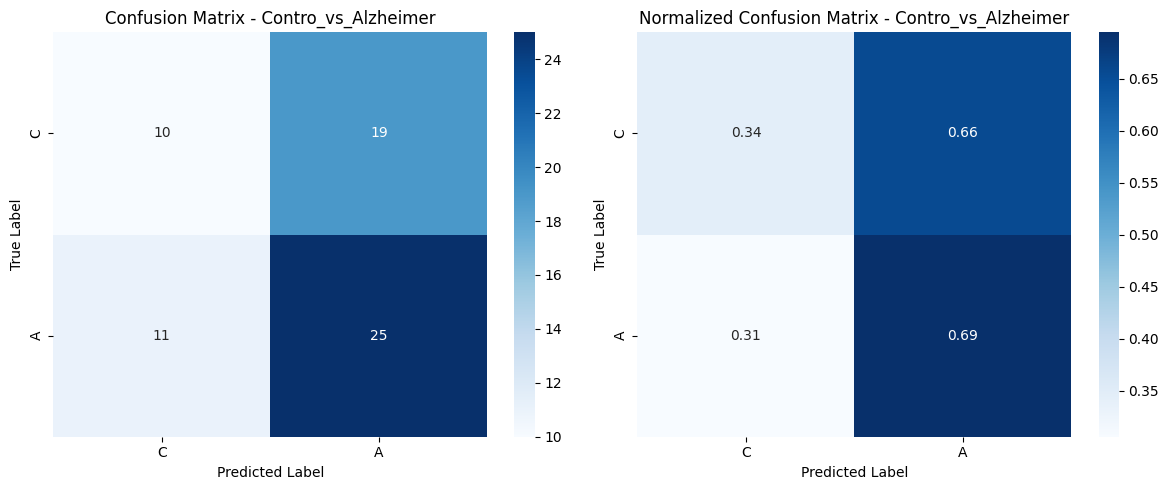


VALUTAZIONE ESPERIMENTO: Contro_vs_Frontotemporal

Evaluating LOSO experiment: Contro_vs_Frontotemporal
Found models directory: experiment_loso/Contro_vs_Frontotemporal

Evaluating subject: sub-037
   True: C, Pred: F, Correct: False, Seg_Acc: 0.434

Evaluating subject: sub-038
   True: C, Pred: C, Correct: True, Seg_Acc: 0.705

Evaluating subject: sub-039
   True: C, Pred: C, Correct: True, Seg_Acc: 0.918

Evaluating subject: sub-040
   True: C, Pred: C, Correct: True, Seg_Acc: 0.831

Evaluating subject: sub-041
   True: C, Pred: C, Correct: True, Seg_Acc: 0.998

Evaluating subject: sub-042
   True: C, Pred: F, Correct: False, Seg_Acc: 0.342

Evaluating subject: sub-043
   True: C, Pred: C, Correct: True, Seg_Acc: 0.631

Evaluating subject: sub-044
   True: C, Pred: C, Correct: True, Seg_Acc: 0.596

Evaluating subject: sub-045
   True: C, Pred: F, Correct: False, Seg_Acc: 0.299

Evaluating subject: sub-046
   True: C, Pred: F, Correct: False, Seg_Acc: 0.187

Evaluating subject: sub-0

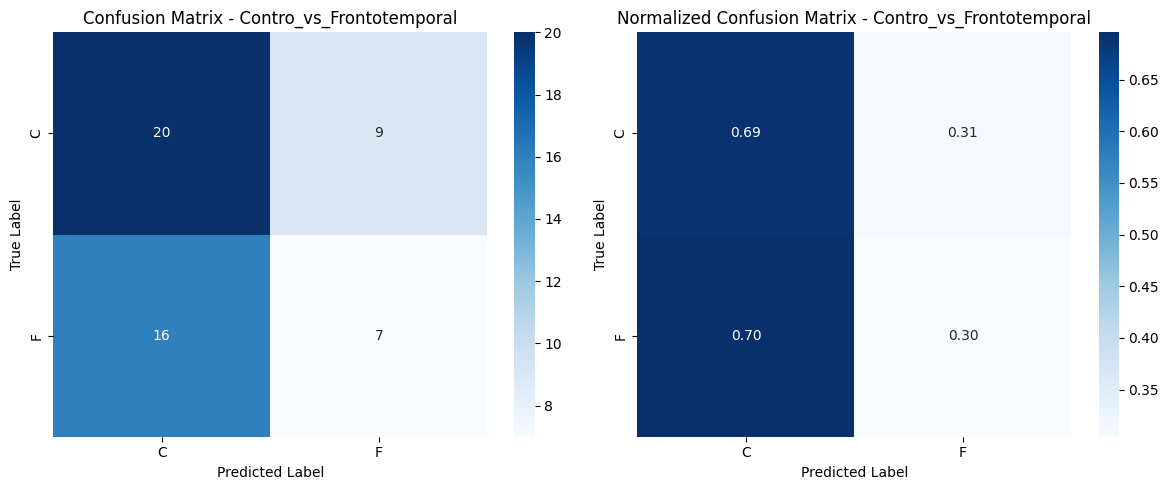


VALUTAZIONE ESPERIMENTO: Frontotemporal_vs_Alzheimer

Evaluating LOSO experiment: Frontotemporal_vs_Alzheimer
Found models directory: experiment_loso/Frontotemporal_vs_Alzheimer

Evaluating subject: sub-001
   True: A, Pred: A, Correct: True, Seg_Acc: 0.843

Evaluating subject: sub-002
   True: A, Pred: A, Correct: True, Seg_Acc: 0.987

Evaluating subject: sub-003
   True: A, Pred: A, Correct: True, Seg_Acc: 0.864

Evaluating subject: sub-004
   True: A, Pred: A, Correct: True, Seg_Acc: 0.503

Evaluating subject: sub-005
   True: A, Pred: F, Correct: False, Seg_Acc: 0.174

Evaluating subject: sub-006
   True: A, Pred: A, Correct: True, Seg_Acc: 0.984

Evaluating subject: sub-007
   True: A, Pred: A, Correct: True, Seg_Acc: 0.738

Evaluating subject: sub-008
   True: A, Pred: A, Correct: True, Seg_Acc: 0.805

Evaluating subject: sub-009
   True: A, Pred: A, Correct: True, Seg_Acc: 0.896

Evaluating subject: sub-010
   True: A, Pred: F, Correct: False, Seg_Acc: 0.288

Evaluating subject

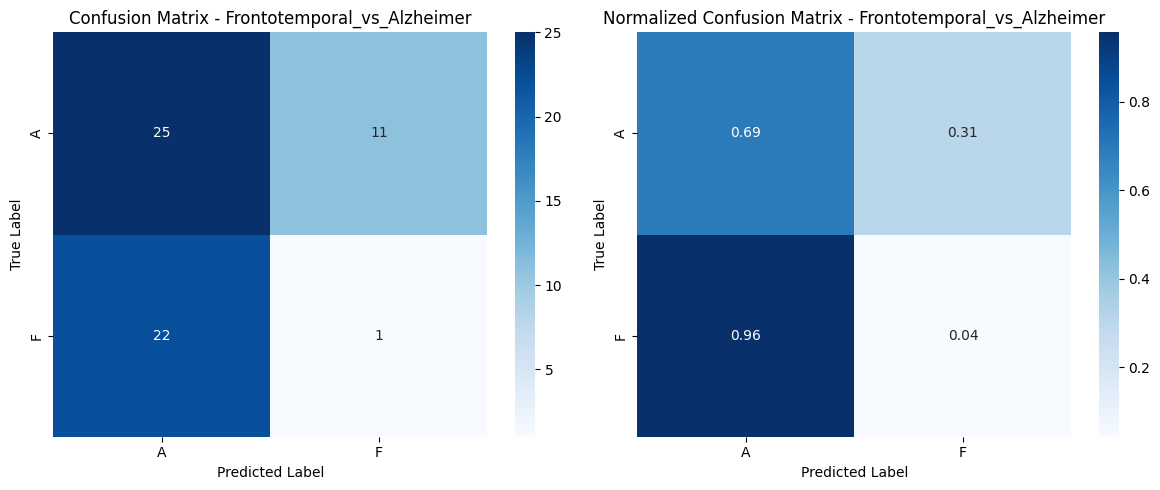


VALUTAZIONE ESPERIMENTO: Contro_vs_Patologici

Evaluating LOSO experiment: Contro_vs_Patologici
Found models directory: experiment_loso/Contro_vs_Patologici

Evaluating subject: sub-001
   True: A, Pred: F, Correct: True, Seg_Acc: 0.887

Evaluating subject: sub-002
   True: A, Pred: F, Correct: True, Seg_Acc: 0.995

Evaluating subject: sub-003
   True: A, Pred: F, Correct: True, Seg_Acc: 1.000

Evaluating subject: sub-004
   True: A, Pred: F, Correct: True, Seg_Acc: 0.881

Evaluating subject: sub-005
   True: A, Pred: F, Correct: True, Seg_Acc: 0.844

Evaluating subject: sub-006
   True: A, Pred: F, Correct: True, Seg_Acc: 0.940

Evaluating subject: sub-007
   True: A, Pred: F, Correct: True, Seg_Acc: 0.790

Evaluating subject: sub-008
   True: A, Pred: F, Correct: True, Seg_Acc: 0.815

Evaluating subject: sub-009
   True: A, Pred: F, Correct: True, Seg_Acc: 1.000

Evaluating subject: sub-010
   True: A, Pred: F, Correct: True, Seg_Acc: 0.580

Evaluating subject: sub-011
   True: A, P

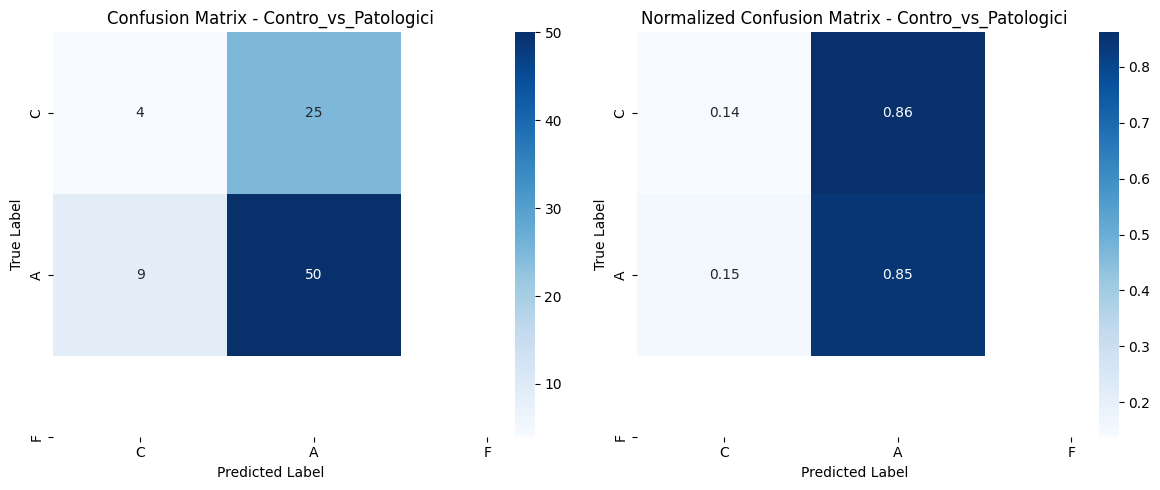

In [54]:
all_results = evaluate_multiple_experiments()

In [ ]:
#Salvataggio
experiments = [
        {
            'name': 'Contro_vs_Alzheimer',
            'classes': ['C', 'A'],
            'label_mapping': {'C': 0, 'A': 1}
        },
        {
            'name': 'Contro_vs_Frontotemporal',
            'classes': ['C', 'F'],
            'label_mapping': {'C': 0, 'F': 1}
        },
        {
            'name': 'Frontotemporal_vs_Alzheimer',
            'classes': ['A', 'F'],
            'label_mapping': {'A': 0, 'F': 1}
        },
        {
            'name': 'Contro_vs_Patologici',
            'classes': ['C', 'A', 'F'],
            'label_mapping': {'C': 0, 'A': 1, 'F': 1}
        }
    ]

path = "experiment_loso/loso_results"
for exp in experiments:
    save_results_to_file(all_results[exp['name']],path,  filename=f"loso_results_{exp['name']}.json")

Risultati salvati in: experiment_loso/loso_results/loso_results_Contro_vs_Alzheimer.json
Risultati salvati in: experiment_loso/loso_results/loso_results_Contro_vs_Frontotemporal.json
Risultati salvati in: experiment_loso/loso_results/loso_results_Frontotemporal_vs_Alzheimer.json
Risultati salvati in: experiment_loso/loso_results/loso_results_Contro_vs_Patologici.json


: 